## Machine Learning Final Project. Script 2

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

### Step 1: read data and identify X and Y matrices  

In [2]:
features_likes = pd.read_csv('features_likes_subset.csv')

In [3]:
features_likes.shape

(47315, 4229)

In [4]:
features_likes.head()

,item_id,0,1,2,3,4,5,6,7,8,...,user706785,user710842,user767704,user800925,user832746,user85339,user870388,user907377,user932612,user97170
0,40000,0.000000,5.768070,0.0,1.791511,0.000000,0.000000,0.000000,2.251129,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40022,0.000000,0.000000,0.0,1.481569,3.952707,2.005341,0.195760,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40038,0.707493,0.361831,0.0,0.000000,2.351708,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40047,0.015068,0.000000,0.0,0.000000,0.000000,3.658680,0.112402,0.000000,1.619776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40072,0.000000,0.000000,0.0,0.000000,0.030398,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First, we divide the data into X and Y matrices

In [5]:
X= features_likes.iloc[:,1:4097]
Y= features_likes.iloc[:, 4097:]

In [6]:
X.shape

(47315, 4096)

In [7]:
Y.shape

(47315, 132)

### Step 2: Descriptive statistics 

1) Users and tastes: 

The following graph allows to vizualize the sparsity of the Y matrix for the first 100 items (vertical axis) and 100 users (horizontal axis). The black pixels represent the likes (1s) and the white the 0s. 

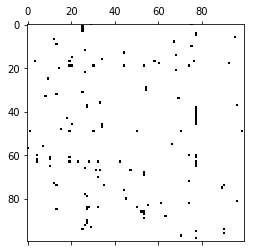

In [10]:
plt.spy(Y.iloc[:100,:100])

The following density plot shows that most users in our sample have between 500 and 1000 likes. 

In [13]:
total_likes_per_user = Y.sum(0)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


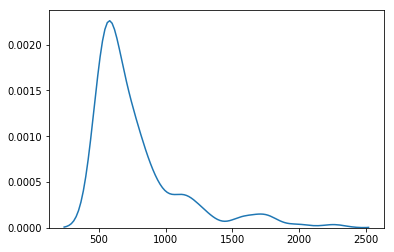

In [16]:
sns.kdeplot(total_likes_per_user)

In [17]:
total_likes_per_user = pd.DataFrame(total_likes_per_user)

Looking at descriptive statistics we see that out of our 132 users, the mean value of likes is 780, with a standard deviation of 340. The minimum number of likes is 501 (which is what we expected given our selection). The most active user liked 2,260 images.

In [18]:
total_likes_per_user.describe()

,0
count,132.000000
mean,780.674242
std,340.677491
min,501.000000
25%,551.500000
50%,652.000000
75%,845.500000
max,2260.000000


As for the items, the mean number of likes per item is 2.2 with a standard deviation of 3.8. The distribution seems to be slightly bimodal with a few more items with more than 50 likes. The maximum number of likes is 60. 

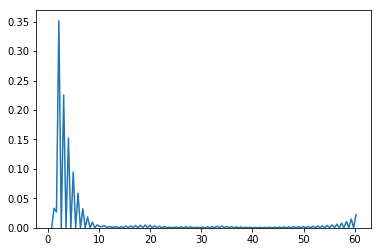

In [21]:
total_likes_per_item = Y.sum(1)
sns.kdeplot(total_likes_per_item)


In [22]:
total_likes_per_item = pd.DataFrame(total_likes_per_item)
total_likes_per_item.describe()

,0
count,47315.000000
mean,2.177935
std,3.833593
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,60.000000


2) Features 

We select the first item to visualize what the features look like: 

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [23]:
feature_maps= np.array(X.iloc[0,:])

In [24]:
feature_maps.shape = (8,8,64)#64 are the number of channels of the first layer of VGG 

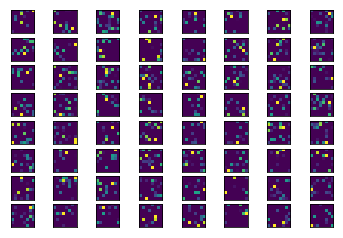

In [26]:
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[ :, :, ix-1]) #, cmap='gray')
        ix += 1
# show the figure
plt.show()

### Step 3: Base model 

#### Logistic regression with gradient descent and MultiOutputClassifier 

In [8]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=222, shuffle=True)

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
clf = SGDClassifier(loss="log", max_iter=1000, tol = 0.1, early_stopping = True)
multi_target_model = MultiOutputClassifier(clf)
mod_1 = multi_target_model.fit(X_train, Y_train)

In [10]:
#save model in disk 
import pickle
filename = 'log_model_multioutput.sav'
pickle.dump(mod_1, open(filename, 'wb'))

In [9]:
#open model form pickle 
import pickle 
filename = 'log_model_multioutput.sav'
model_log = pickle.load(open(filename, 'rb'))

In [35]:
Y_pred_test = model_log.predict(X_test)

In [10]:
Y_pred_proba = model_log.predict_proba(X_test)

In [23]:
Y_pred_proba = np.array(Y_pred_proba)
Y_score_positive = [Y_pred_proba[i][j][1] for j in range(14195) for i in range(132)]
Y_score_positive = np.array(Y_score_positive)

In [25]:
Y_score_positive.shape = 14195, 132 

In [31]:
from sklearn.metrics import precision_score, recall_score
def evaluate_thresholds(Y_prob):
    threshold=list(np.arange(0.001,0.5, 0.001))
    precision=[]
    recall = []
    for i in threshold: 
        Y_pred_thr = np.where(Y_prob > i, 1, 0)
        precision.append(precision_score(Y_test, Y_pred_thr, average = 'micro'))
        recall.append(recall_score(Y_test, Y_pred_thr, average = 'micro'))

    data_thresholds = pd.DataFrame(threshold)
    data_thresholds = data_thresholds.rename(columns = {0:'threshold'})
    data_thresholds['precision'] = precision
    data_thresholds['recall']= recall
    
    return data_thresholds

In [32]:
data_th = evaluate_thresholds(Y_score_positive)

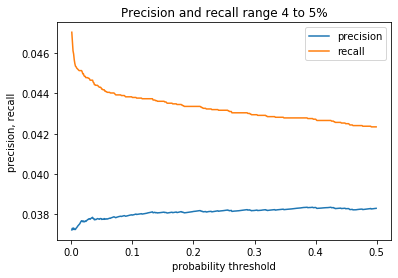

In [36]:
plt.plot(data_th['threshold'], data_th['precision'])
plt.plot(data_th['threshold'], data_th['recall'])
plt.title('Precision and recall range 4 to 5%')
plt.ylabel('precision, recall')
plt.xlabel('probability threshold')
plt.legend(['precision', 'recall'], loc='upper right')
plt.show()

In [42]:
Y_test = Y_test.values

In [48]:
from sklearn.metrics import confusion_matrix 
cm = pd.DataFrame(confusion_matrix(Y_test.flatten(), Y_pred_test.flatten()))

In [49]:
cm

,0,1
0,1808784,33473
1,30150,1333


In [56]:
cm_perc = round(cm*(1/1873740)*100,2)

In [57]:
cm_perc

,0,1
0,96.53,1.79
1,1.61,0.07


In [52]:
from sklearn.metrics import classification_report
print(classification_report(Y_test.flatten(), Y_pred_test.flatten()))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98   1842257
         1.0       0.04      0.04      0.04     31483

    accuracy                           0.97   1873740
   macro avg       0.51      0.51      0.51   1873740
weighted avg       0.97      0.97      0.97   1873740



In [59]:
print('Precision:', precision_score(Y_test, Y_pred_test, average = 'micro'))
print('Recall:', recall_score(Y_test, Y_pred_test, average = 'micro'))

Precision: 0.038297994598632416
Recall: 0.04234031064383953
